In [2]:
FN = '160306-segment'

In [3]:
FN0='160306-FCN_tutorial'

In [4]:
from utils import Dataset, params, Nt, Nv, Ns, temp_dir, awscp
Na = Nt+Nv+Ns
Nt, Nv, Ns

(500, 200, 440)

In [5]:
!rm -rf {temp_dir}/output.fcn
awscp(FN0 + '.output.fcn.tgz')
!cd {temp_dir} ; tar xf {FN0}.output.fcn.tgz

In [6]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from joblib import Parallel, delayed
import itertools
import numpy as np
import cv2

In [7]:
from scipy.fftpack import fftn, ifftn
import cv2

def get_H1(images):
    # filter first harmonic for each pixel
    ff = fftn(images)
    first_harmonic = ff[1, :, :]
    result = np.absolute(ifftn(first_harmonic))
    # blur between pixels
    result = cv2.GaussianBlur(result, (5, 5), 0)
    return result

def get_H1_noise(images):
    num_slices = len(images)
    h1s = np.array([get_H1(images[i]) for i in range(num_slices)])
    # noise reduction
#     thr = np.sort(h1s.ravel())
#     for mm in [0.05,0.1,0.15,0.2]: # 0.15
#         m = np.max(h1s) * mm
#         print mm, np.where(thr > m)[0][0]/float(len(thr))
#     m = thr[int(len(thr)*0.994)]

#     for i in range(len(h1s)):
#         m = np.max(h1s[i]) * 0.1
#         h1s[i][h1s[i] < m] = 0
    m = np.max(h1s) * 0.2
    h1s[h1s < m] = 0
    return h1s

In [8]:
import statsmodels.api as sm
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

def weighted_linregress(x, y, weights):
#     print 'x=',x
#     print 'y=',y
#     print 'weights=',weights
#     #return linregress(x, y)[:2]
#     X = np.c_[x, np.ones_like(x)]
    
    
# #     mod = sm.RLM(y, X)
# #     rlm_weights = mod.fit().weights
# #     print 'rlm_weights',rlm_weights
# #     mod_wls = sm.WLS(mod.endog, mod.exog, weights=weights*rlm_weights)
    
#     mod_wls = sm.WLS(y, X, weights=weights)
#     res_wls = mod_wls.fit()
#     return res_wls.params

    x0 = np.reshape(x,(-1,1))
    clf = BaggingRegressor(Ridge(alpha=1e-4), max_samples=.7)
    clf.fit(x0, np.array(y), np.array(weights))
    
    intercepts = np.array([l.intercept_ for l in clf.estimators_])
    slopes = np.array([l.coef_[0] for l in clf.estimators_])
    islope = np.argsort(np.abs(slopes))[int(0.3*len(x))]
    
    return slopes[islope], intercepts[islope]
#     clf = Ridge(alpha=1e-4)
#     clf.fit(x0, np.array(y), np.array(weights))
#     return clf.intercept_, clf.coef_[0]

In [9]:
from scipy.stats import linregress
from scipy.spatial.distance import euclidean
from scipy.optimize import curve_fit

# number of bins to use in histogram for gaussian regression
NUM_BINS = 100
# number of standard deviations past which we will consider a pixel an outlier
STD_MULTIPLIER = 2

def get_centroid(img):
    """
    return cetnroid location of 2D or 3D img. The result is in reverse order: (y,x) or (z,y,z)
    """
    # 2D/3D coordinate of all non zero elements
    nz = np.nonzero(img)
    if not nz or len(nz[0]) < 1:
        print "EMPTY"        
        return (-2,-2)
    pxls = np.transpose(nz)
    # use pixel value as weight
    weights = img[nz]
    if weights.sum() < 1e-8:
        print "EMPTY"
        return (-1,-1)    
    
    CNT = np.array(img.shape[-2:])/2.
    R = CNT.max()
    CNT = CNT[None,:]
    
#     pxwt = [(px,wt) for px,wt in itertools.izip(pxls,weights) if np.any(np.abs(px - CNT) < R)]
#     pxls, weight = itertools.izip(*pxwt)
    weights /= (R/4. + np.linalg.norm(pxls[:,-2:] - CNT, axis=1,ord=1))
    
    # average over all 3D coordinates using the pixel value as weight
    # axis=0 is the list of non zero pixels (not the Z dimension)
    avg = np.average(pxls, axis=0, weights=weights)
    return avg

def regress_centroids(cs, imgs):
    # Build separatly for x and y a linear regression between slice number and the centroid cordinate
    num_slices = len(cs)
    assert num_slices == len(imgs)
    y_centroids = cs[:, 0]
    x_centroids = cs[:, 1]
    z_values = np.array(range(num_slices))
    weights = imgs.reshape((num_slices,-1)).mean(axis=-1)
                           
    mask = y_centroids >= 0
    y_centroids = y_centroids[mask]
    x_centroids = x_centroids[mask]
    z_values = z_values[mask]
    weights = weights[mask] / (np.abs(z_values - z_values.mean()) + num_slices/2.)
    num_slices = len(cs)
    if num_slices == 0:
        return 0,128,0,128
    if num_slices == 1:
        return (0., x_centroids[0], 0., y_centroids[0])

    xslope, xintercept = weighted_linregress(z_values, x_centroids, weights)
    yslope, yintercept = weighted_linregress(z_values, y_centroids, weights)

    return (xslope, xintercept, yslope, yintercept)

def get_weighted_distances(imgs, coords, xs, xi, ys, yi):
    # return the coordinates of every non zero pixel, its distance from centroid line and weight (pixel value)
    a = np.array([0, yi, xi])
    n = np.array([1, ys, xs])/np.sqrt(1.*1. + ys*ys + xs*xs)

    zeros = np.zeros(3)

    def dist(p):
        to_line = (a - p) - (np.dot((a - p), n) * n)
        d = euclidean(zeros, to_line)
        return d

    def weight(p):
        (z, y, x) = p
        return imgs[z, y, x]

    dists = np.array([dist(c) for c in coords])
    weights = np.array([weight(c) for c in coords])
    return (coords, dists, weights)

def histogram_transform(values, weights):
    hist, bins = np.histogram(values, bins=NUM_BINS, weights=weights)
    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + (bin_width / 2)

    return (bin_centers, hist)


def gaussian_fit(dists, weights):
    # convert distances/weights to distribution (histogram)
    # and fit a gausian shape to it, return mu, std and the fit
    # based on http://stackoverflow.com/questions/11507028/fit-a-gaussian-function
    (x, y) = histogram_transform(dists, weights)
    fivep = int(len(x) * 0.05)
    xtmp = x
    ytmp = y
    fromFront = False
    while True:
        if len(xtmp) == 0 and len(ytmp) == 0:
            if fromFront:
                # well we failed
                idx = np.argmax(y)
                xmax = x[idx]
                p0 = [max(y), xmax, xmax]
                (A, mu, sigma) = p0
                return mu, sigma, lambda x: gauss(x, A, mu, sigma)
            else:
                fromFront = True
                xtmp = x
                ytmp = y

        # find mode
        idx = np.argmax(ytmp)
        xmax = xtmp[idx]

        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))

        p0 = [max(ytmp), xmax, xmax]
        try:
            coeff, var_matrix = curve_fit(gauss, xtmp, ytmp, p0=p0)
            (A, mu, sigma) = coeff
            return (mu, sigma, lambda x: gauss(x, A, mu, sigma))
        except RuntimeError:
            if fromFront:
                xtmp = xtmp[fivep:]
                ytmp = ytmp[fivep:]
            else:
                xtmp = xtmp[:-fivep]
                ytmp = ytmp[:-fivep]


def get_outliers(coords, dists, weights):
    fivep = int(len(weights) * 0.05)
    ctr = 1
    while True:
        (mean, std, fn) = gaussian_fit(dists, weights)
        low_values = dists < (mean - STD_MULTIPLIER*np.abs(std))
        high_values = dists > (mean + STD_MULTIPLIER*np.abs(std))
        outliers = high_values
#         outliers = np.logical_or(low_values, high_values)
        if len(coords[outliers]) == len(coords):
            # if all are outliers then throw away 5% of all weights and repeat
            weights[-fivep*ctr:] = 0
            ctr += 1
        else:
            return coords[outliers]

def regress_and_filter_distant(imgs):
    # find centroid of each slice, pass a line through them, find distance to line of each pixel
    # build a gaussian fit and zero outliers.
    
    # find center of mass of each slice
    centroids = np.array([get_centroid(img) for img in imgs])
    # Build separatly for x and y a linear regression between slice number and the centroid cordinate
    (xslope, xintercept, yslope, yintercept) = regress_centroids(centroids,imgs)
#     xslope *=0.5
#     yslope *=0.5
    raw_coords = np.transpose(np.nonzero(imgs))
    # return the coordinates of every non zero pixel, its distance from centroid line and weight (pixel value)
    (coords, dists, weights) = get_weighted_distances(imgs, raw_coords,
                                                      xslope, xintercept,
                                                      yslope, yintercept)
    outliers = get_outliers(coords, dists, weights)
    imgs_cpy = np.copy(imgs)
    for c in outliers:
        (z, x, y) = c
        imgs_cpy[z, x, y] = 0
    return imgs_cpy

def regression_filter(imgs):
    dc = 10
    iternum = 0
    while dc > 1.0:
        iternum += 1
        imgs_filtered = regress_and_filter_distant(imgs)
#         if any([img.sum() < 1e-6 for img in imgs_filtered]):
#             c2 = get_centroid(imgs)
#             break
        c1 = get_centroid(imgs)
        c2 = get_centroid(imgs_filtered)
        dc = np.linalg.norm(c1 - c2)
        imgs = imgs_filtered
    return imgs,c2

In [10]:
def post_process_regression(imgs):
    #assemble a distribution for each slice and filter them separately
    (numimgs, _, _) = imgs.shape
    centroids = np.array([get_centroid(img) for img in imgs])
    (xslope, xintercept, yslope, yintercept) = regress_centroids(centroids,imgs)
    imgs_cpy = np.copy(imgs)

    def filter_one_img(zlvl):
        points_on_zlvl = np.transpose(imgs[zlvl].nonzero())
        if len(points_on_zlvl) == 0:
            return
        points_on_zlvl = np.insert(points_on_zlvl, 0, zlvl, axis=1)
        (coords, dists, weights) = get_weighted_distances(imgs, points_on_zlvl,
                                                          xslope, xintercept,
                                                          yslope, yintercept)
        outliers = get_outliers(coords, dists, weights)
        for c in outliers:
            (z, x, y) = c
            imgs_cpy[z, x, y] = 0

    for z in range(numimgs):
        filter_one_img(z)

    return (imgs_cpy, (xslope, xintercept, yslope, yintercept))

In [11]:
def floats_draw_circle(img, center, r, color, thickness):
    (x, y) = center
    x, y = int(np.round(x)), int(np.round(y))
    r = int(np.round(r))
    cv2.circle(img, center=(x, y), radius=r, color=color, thickness=thickness)

def filled_ratio_of_circle(img, center, r):
    # ratio of non zero inside ROI to total number of non zero pixels inside ROI
    mask = np.zeros_like(img)
    floats_draw_circle(mask, center, r, 1, -1)
    masked = mask * img
    (x, _) = np.nonzero(mask)
    (x2, _) = np.nonzero(masked)
    if x.size == 0:
        return 0
    return float(x2.size) / x.size


def circle_smart_radius(img, center, pow=1):
    domain = np.arange(1, 100)
    (xintercept, yintercept) = center

    def ratio(r):
        return filled_ratio_of_circle(img, (xintercept, yintercept), r)*(r**pow)

    y = np.array([ratio(d) for d in domain])
    most = np.argmax(y)
    return domain[most]

def get_ROIs(originals, h1s, regression_params, rscale=1., pow=1):
    """ROI center is determined by the regression line.
    ROI radius max radius TIMEs the ratio of non zero pixels to total number of pixels inside radius"""
    (xslope, xintercept, yslope, yintercept) = regression_params
    (num_slices, _, _) = h1s.shape

    circles = []
    for i in range(num_slices):
        h = h1s[i]
        ctr = (xintercept + xslope * i, yintercept + yslope * i)
        r = circle_smart_radius(h, ctr, pow=pow)
        circles.append((ctr, r))
    
    max_circle_slice = max(enumerate(circles), key=lambda x: x[1][1])[0]
    
    for i in range(max_circle_slice+1, num_slices):
        if circles[i][1] <= 1:
            circles[i] = (circles[i][0],circles[i-1][1])
            
    for i in range(max_circle_slice-1, -1, -1):
        if circles[i][1] <= 1:
            circles[i] = (circles[i][0],circles[i+1][1])
                
    results = []
    for i in range(num_slices):
        o = originals[i]
        ctr, r = circles[i]
        if rscale != 1.:
            r *= rscale
            circles[i] = (ctr, r)
        tmp = np.zeros_like(o)
        floats_draw_circle(tmp, ctr, r, 1, -1)
        results.append(tmp * o)

    return (np.array(results), np.array(circles))

def get_closest_slice(rois):
    ctrd = get_centroid(rois)
    closest_slice = int(np.round(ctrd[0]))
    return closest_slice, ctrd


In [12]:
from skimage import transform as tf

def get_crop(images, circle, S=128, rscale=1.,minscale=0.):
    results = []
    ctr, r = circle
    r *= rscale
    scale = (2.*r)/float(S)
    scale = max(scale, minscale)
    s = S*scale
    tform = tf.AffineTransform(translation=(ctr[0]-s/2.,ctr[1]-s/2.),scale=(scale,scale))
    T = len(images)
    for t in range(T):
        o = images[t] # * (1.+0.*proc_regress_h1s[center_slice]/proc_regress_h1s[center_slice].max())
        o_small = tf.warp(o, tform)[:S,:S]
        if min(o_small.shape) < S:
            h, w = o_small.shape
            o_small_bigger = np.zeros((S,S))
            o_small_bigger[(S-h)//2:((S-h)//2+h),(S-w)//2:((S-w)//2+w)] = o_small
            o_small = o_small_bigger
        results.append(o_small)
    return np.array(results), scale

In [13]:
from scipy.signal import argrelmin, correlate
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import label


# number of points of our interpolated dataset to consider when searching for
# a threshold value; the function by default is interpolated over 1000 points,
# so 250 will look at the half of the points that is centered around the known
# myocardium pixel
THRESHOLD_AREA = 250
# number of pixels on the line within which to search for a connected component
# in a thresholded image, increase this to look for components further away
COMPONENT_INDEX_TOLERANCE = 20
# number of angles to search when looking for the correct orientation
ANGLE_SLICES = 36
EROD=1
EROD_PROP=4
MEAN_PROP_SCALE=1.3


def find_threshold_point(best, best_fn):
    fn, trimx, trim_coords = best_fn
    dom = np.linspace(np.min(trimx), np.max(trimx), 1000)
    f = fn(dom)
    mins = argrelmin(f)
    if len(mins[0]) == 0:
        mins = (np.argmin(f),)

    closest_min = -1
    closest_dist = -1
    for m in np.nditer(mins):
        dist = np.abs(500 - m)
        if closest_min == -1 or closest_dist > dist:
            closest_min = m
            closest_dist = dist

    fnprime = fn.derivative()
    restrict = dom[np.max(closest_min-THRESHOLD_AREA, 0):
                   closest_min+THRESHOLD_AREA]
    f2 = fnprime(restrict)

    m1 = restrict[np.argmax(f2)]
    mean = fn(m1)

    idx = np.min([int(np.floor(m1))+1, len(trim_coords)-1])
    return (mean, trim_coords, idx)

def get_line_coords(w, h, cx, cy, theta):
    coords = np.floor(np.array(line_thru((0, w-1, 0, h-1), (cx, cy), theta)))
    return coords.astype(np.int)

def bresenham(x0, x1, y0, y1, fn):
    # using some pseudocode from
    # https://en.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm
    # and also https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    steep = abs(y1-y0) > abs(x1-x0)
    if steep:
        x0, x1, y0, y1 = y0, y1, x0, x1
    if x0 > x1:
        x0, x1, y0, y1 = x1, x0, y1, y0

    def plot(x, y):
        if steep:
            fn(y, x)
        else:
            fn(x, y)

    dx = x1 - x0
    dy = y1 - y0

    D = 2*np.abs(dy) - dx
    plot(x0, y0)
    y = y0

    for x in range(x0+1, x1+1):  # x0+1 to x1
        D = D + 2*np.abs(dy)
        if D > 0:
            y += np.sign(dy)
            D -= 2*dx
        plot(x, y)

def trim_zeros_indices(has_zeros):
    first = 0
    for i in has_zeros:
        if i == 0:
            first += 1
        else:
            break

    last = len(has_zeros)
    for i in has_zeros[::-1]:
        if i == 0:
            last -= 1
        else:
            break

    return first, last


def get_line(roi, cx, cy, theta):
    (h, w) = roi.shape
    (x0, x1, y0, y1) = get_line_coords(w, h, cx, cy, theta)

    intensities = []
    coords = []

    def collect(x, y):
        if y < 0 or y >= h or x < 0 or x >= w:
            return
        intensities.append(roi[y, x])
        coords.append((x, y))

    bresenham(x0, x1, y0, y1, collect)

    def geti(idx):
        return intensities[idx]

    getiv = np.vectorize(geti)
    x = np.arange(0, len(intensities))
    y = getiv(x)
    first, last = trim_zeros_indices(y)
    trimy = y[first:last]
    trimcoords = coords[first:last]

    trimx = np.arange(0, trimy.size)
    return (trimx, trimy, trimcoords)

def line_thru(bounds, center, theta):
    (xmin, xmax, ymin, ymax) = bounds
    (cx, cy) = center

    if np.cos(theta) == 0:
        return (cx, ymin, cx, ymax)
    slope = np.tan(theta)

    x0 = xmin
    y0 = cy - (cx - xmin) * slope
    if y0 < ymin:
        y0 = ymin
        x0 = max(xmin, cx - ((cy - ymin) / slope))
    elif y0 > ymax:
        y0 = ymax
        x0 = max(xmin, cx - ((cy - ymax) / slope))

    x1 = xmax
    y1 = cy + (xmax - cx) * slope
    if y1 < ymin:
        y1 = ymin
        x1 = min(xmax, cx + ((ymin - cy) / slope))
    elif y1 > ymax:
        y1 = ymax
        x1 = min(xmax, cx + ((ymax - cy) / slope))

    return (x0, x1, y0, y1)

def find_best_angle(roi, circ):
    ((cx, cy), r) = circ
    results = np.zeros(ANGLE_SLICES)
    fns = [None for i in range(ANGLE_SLICES)]

    COS_MATCHED_FILTER_FREQ = 2.5

    def score_matched(trimx, trimy):
        # first, normalize this data
        newtrimx = np.linspace(0.0, 1.0, np.size(trimx))
        minimum = np.min(trimy)
        maximum = np.max(trimy) - minimum
        newtrimy = (trimy - minimum) / maximum

        filt = 1 - ((np.cos(COS_MATCHED_FILTER_FREQ*2*np.pi*newtrimx)) /
                    2 + (0.5))
        cr = correlate(newtrimy, filt, mode="same")
        return np.max(cr)

    for i in range(ANGLE_SLICES):
        trimx, trimy, trimcoords = get_line(roi, cx, cy, np.pi*i/ANGLE_SLICES)
        score2 = score_matched(trimx, trimy)
        results[i] = score2
        fns[i] = (UnivariateSpline(trimx, trimy), trimx, trimcoords)

    best = np.argmax(results)
    return (best * np.pi / ANGLE_SLICES, fns[best])

def locate_lv_blood_pool(images, rois, circles, closest_slice, time):
    best, best_fn = find_best_angle(rois[closest_slice],
                                    circles[closest_slice])
    mean, coords, idx = find_threshold_point(best, best_fn)
    kernel = np.ones((3,3),np.uint8)
    for mean_scale in range(10):
        thresh, img_bin = cv2.threshold(images[closest_slice,
                                               time].astype(np.float32),
                                        mean, 255.0, cv2.THRESH_BINARY)
        img_erosion = cv2.erode(img_bin,kernel,iterations = EROD)
        labeled, num = label(img_erosion)
        x, y = coords[idx]

        count = 0
        # Look along the line for a component. If one isn't found within a certain
        # number of indices, just spit out the original coordinate.
        while labeled[y][x] == 0:
            idx += 1
            count += 1
            x, y = coords[idx]
            if count > COMPONENT_INDEX_TOLERANCE:
                idx -= count
                x, y = coords[idx]
                break
        if count <= COMPONENT_INDEX_TOLERANCE:
            break
        mean *= 0.9

    if count <= COMPONENT_INDEX_TOLERANCE:
        img_dilate = cv2.dilate(img_erosion,kernel,iterations = EROD)
        labeled, num = label(img_bin*img_dilate)
        component = np.transpose(np.nonzero(labeled == labeled[y][x]))
    else:
        print "No COMPONENT_INDEX_TOLERANCE"
        component = np.array([[y, x]])

    hull = cv2.convexHull(component)
    squeezed = hull
    if count <= COMPONENT_INDEX_TOLERANCE:
        squeezed = np.squeeze(squeezed)
    hull = np.fliplr(squeezed)

    mask = np.zeros_like(labeled)
    cv2.drawContours(mask, [hull], 0, 255, thickness=-1)
    return mask, mean

def propagate_segments(images, rois, base_mask, mean, closest_slice, time):
    def propagate_segment(i, mask):
        thresh, img_bin = cv2.threshold(images[i,
                                               time].astype(np.float32),
                                        mean, 255.0, cv2.THRESH_BINARY)

        kernel = np.ones((3,3),np.uint8)
        img_erosion = cv2.erode(img_bin,kernel,iterations = EROD_PROP)
        labeled, features = label(img_erosion)

        region1 = mask == 255
        max_similar = -1
        max_region = 0
        for j in range(1, features+1):
            region2 = labeled == j
            intersect = np.count_nonzero(np.logical_and(region1, region2))
            union = np.count_nonzero(np.logical_or(region1, region2))
            similar = float(intersect) / union
            if max_similar == -1 or max_similar < similar:
                max_similar = similar
                max_region = j
        if max_similar <= 0:
#             component = np.transpose(np.nonzero(mask))
            return np.zeros_like(mask)
        else:
            yx = np.where(labeled == max_region)
            y,x = yx[0][0],yx[1][0]
            img_dilate = cv2.dilate(img_erosion,kernel,iterations = EROD_PROP)
            labeled, num = label(img_bin*img_dilate)
            
            component = np.transpose(np.nonzero(labeled == labeled[y][x]))
        hull = cv2.convexHull(component)
        hull = np.squeeze(hull)
        if hull.shape == (2L,):
            hull = np.array([hull])
        hull = np.fliplr(hull)

        newmask = np.zeros_like(img_bin)

        cv2.drawContours(newmask, [hull], 0, 255, thickness=-1)

        return newmask

    (rois_depth, _, _) = rois.shape
    newmask = base_mask
    masks = {}
    areas = {}
    masks[closest_slice] = base_mask
    areas[closest_slice] = np.count_nonzero(base_mask)
    for i in range(closest_slice-1, -1, -1):
        newmask = propagate_segment(i, newmask)
        masks[i] = newmask
        areas[i] = np.count_nonzero(newmask)

    newmask = base_mask
    for i in range(closest_slice+1, rois_depth):
        newmask = propagate_segment(i, newmask)
        masks[i] = newmask
        areas[i] = np.count_nonzero(newmask)

    return masks, areas

def calc_all_areas(images, rois, circles, closest_slice):
#     closest_slice = get_closest_slice(rois)
    (_, times, _, _) = images.shape

    def calc_areas(time):
        mask, mean = locate_lv_blood_pool(images, rois, circles, closest_slice,
                                          time)
        masks, areas = propagate_segments(images, rois, mask, MEAN_PROP_SCALE*mean,
                                          closest_slice, time)
        return (masks, areas)

    result = np.transpose(map(calc_areas, range(times)))
    all_masks = result[0]
    all_areas = result[1]
    return all_masks, all_areas


def calc_total_volume(areas, area_multiplier, dist):
    slices = np.array(sorted(areas.keys()))
    modified = [areas[i] * area_multiplier for i in slices]
    vol = 0
    for i in slices[:-1]:
        a, b = modified[i], modified[i+1]
        subvol = (dist/3.0) * (a + np.sqrt(a*b) + b)
        vol += subvol / 1000.0  # conversion to mL
    return vol

# Data

In [14]:
import json
import os
import scipy

def get_FCN(s, S=None):
    """
        S: int
            Wanted square size of images. Images are zero padded to a sqare
            and then resized to S. If S < 0 then just make the images square if they are not
            See utils.Dataset

    return Dia masks for all slices, time of sys, time of dia
    """
    study =s+1
    fdir = os.path.join(temp_dir,'output.fcn',str(study))
    data1 = json.load(open(os.path.join(fdir,'output.json')))
    all_areas = data1['areas']
    nslices = len(all_areas[0])
    d_areas = map(lambda x: x[1], sorted(all_areas[data1['edi']].items(), key=lambda x: x[0]))
    center_slice = np.argmax(d_areas)
    h1s = np.load(os.path.join(fdir,'h1s.npz'))['arr_0']
    
    out_masks = []
    for img in h1s:
        assert img.shape == h1s[0].shape
        H,W = img.shape
        HW = max(H,W)
        if S is not None and S < 0:
            S = HW
        area_scale = 1.
        if (S is not None) and ((S != H) or (S != W)):
            ox = (HW - H)//2
            oy = (HW - W)//2
            f = np.zeros((HW,HW))
            f[ox:ox+H,oy:oy+W] = img
            img = scipy.misc.imresize(f, (S,S))
            area_scale = (float(HW)/S) * (float(HW)/S)
        out_masks.append(img)

    return np.array(out_masks), center_slice, data1['esi'], data1['edi'], area_scale

# Testing

In [16]:
from utils import Dataset
s=720
dset = Dataset(s+1, prefix='sax')
dset.load(S=-1)

In [17]:
dset.PatientAge,dset.dist,dset.area

(13.0, 7.9800000000000004, 0.42125000000000001)

In [18]:
images = dset.images.copy()
for i, imgs in enumerate(images):
    for j, img in enumerate(imgs):
        images[i,j] = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))

In [19]:
dc = np.mean(images, 1)

In [20]:
images.shape,images.max(),dc.shape

((11, 30, 416, 416), 255, (11, 416, 416))

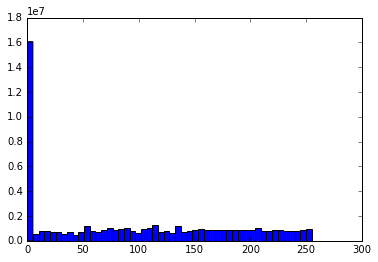

In [21]:
plt.hist(images.ravel(),bins=50);

In [22]:
h1s_fcn, fcn_center_slice, esi, edi, fcn_scale = get_FCN(s, S=-1)
h1s_fcn.shape, fcn_center_slice, esi, edi, fcn_scale

((11, 416, 416), 7, 15, 2, 1.0)

((11, 416, 416), 7, 5)

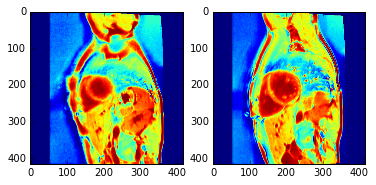

In [23]:
center_slice = fcn_center_slice #len(images)//2
plt.subplot(121)
plt.imshow(dc[center_slice])
plt.subplot(122)
plt.imshow(dc[len(images)//2])

dc.shape,center_slice,len(images)//2

In [24]:
h1s_images = get_H1_noise(images)
h1s_images.shape

(11, 416, 416)

In [25]:
h1s = 0.5*h1s_fcn/h1s_fcn.max() + 0.5*h1s_images/h1s_images.max()

In [26]:
fcn_center_slice, len(images)//2

(7, 5)

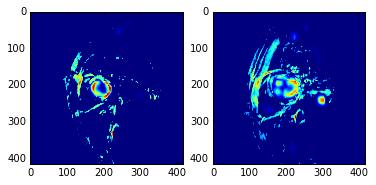

In [27]:
plt.subplot(121)
plt.imshow(h1s[center_slice])
plt.subplot(122)
plt.imshow(h1s[len(images)//2])

In [28]:
h1s = h1s/256.
mask = np.zeros_like(h1s[0])
H,W = mask.shape
for i in range(H):
    for j in range(W):
        mask[i,j] = - ((i-H/2.)**2 + (j-W/2.)**2)/(2.*min(H,W)**2)
mask = np.exp(mask)
mask = mask[None,:,:]
h1s = h1s * mask
        
    
for i, h1s_s in enumerate(h1s):
    h1s[i][h1s_s < h1s_s.max()*0.4] = 0.

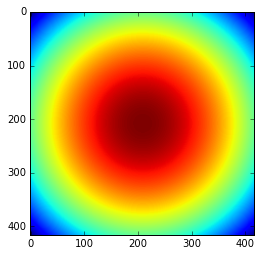

In [29]:
plt.imshow(mask[0])

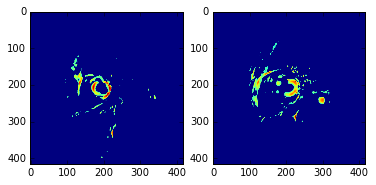

In [30]:
plt.subplot(121)
plt.imshow(h1s[center_slice])
plt.subplot(122)
plt.imshow(h1s[len(images)//2])

[ 241.08355836  137.05207409]
[ 201.82836431  182.51589547]
[ 197.79705048  171.89993202]
[ 192.81539292  185.06251066]
[ 206.27693346  200.17109478]
[ 207.58896565  196.22663432]
[ 205.42956244  189.73651598]
[ 212.43169272  184.65353559]
[ 215.25888855  191.47854611]
[ 227.57245493  192.43761959]
[ 231.75917472  195.97151979]
white dot centroid


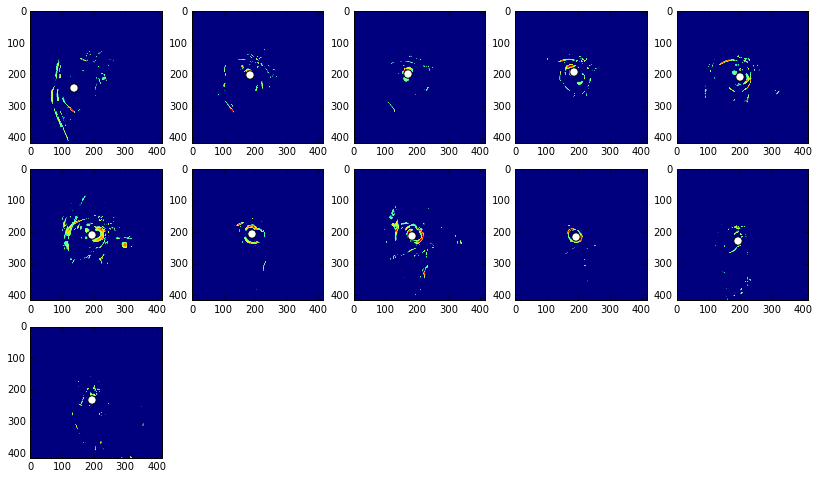

In [31]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(h1s):
    plt.subplot(len(h1s)//5+1,5,i+1)
    cc = get_centroid(ooo)
    print cc
    plt.scatter(cc[1],cc[0],c='w',s=70)
    plt.imshow(ooo)
print "white dot centroid"

In [32]:
def to8(img):
    return np.array(img * 255./img.max(), dtype = np.uint8)

def get_H1_erode(h1s, T=2):
    h1s_erode = []
    for i, h in enumerate(h1s):
        img_erosion = cv2.erode(to8(h),np.ones((3,3),np.uint8),iterations = T)
        img_erosion1 = h*cv2.dilate(img_erosion,np.ones((10,10),np.uint8),iterations = T+10)
        h1s_erode.append(img_erosion1)
    return np.array(h1s_erode)

0.00134492230142


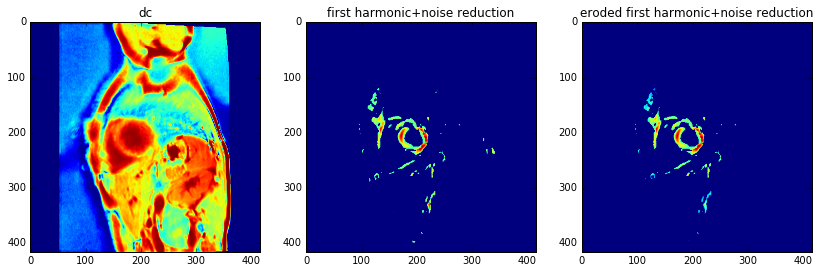

In [33]:
plt.figure(figsize=(14,6))
cc=center_slice

plt.subplot(131)
plt.title('dc')
plt.imshow(dc[cc])

plt.subplot(132)
plt.title('first harmonic+noise reduction')
plt.imshow(h1s[cc])
print h1s[cc].max()

img_erosion1 = get_H1_erode([h1s[cc]])
plt.subplot(133)
plt.title('eroded first harmonic+noise reduction')
plt.imshow(img_erosion1[0])

[ 241.08355836  137.05207409]
[ 201.82836431  182.51589547]
[ 197.79705048  171.89993202]
[ 192.81539292  185.06251066]
[ 206.27693346  200.17109478]
[ 207.58896565  196.22663432]
[ 205.42956244  189.73651598]
[ 212.43169272  184.65353559]
[ 215.25888855  191.47854611]
[ 227.57245493  192.43761959]
[ 231.75917472  195.97151979]
white dot centroid


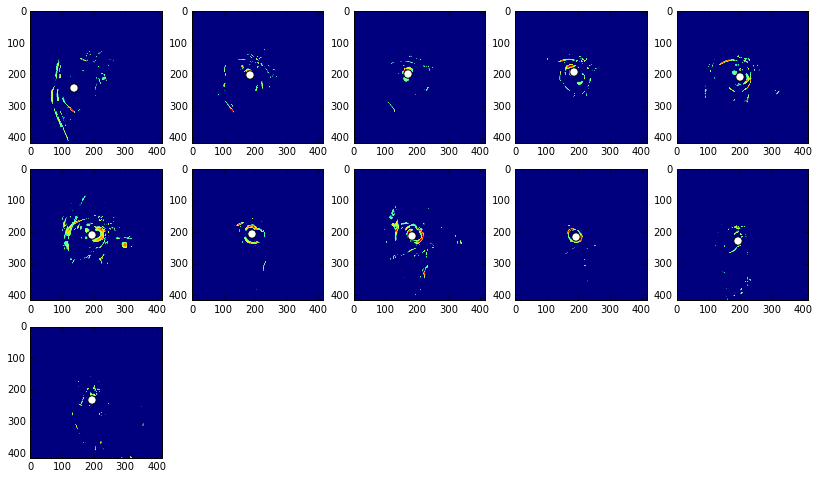

In [34]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(h1s):
    plt.subplot(len(h1s)//5+1,5,i+1)
    cc = get_centroid(ooo)
    print cc
    plt.scatter(cc[1],cc[0],c='w',s=70)
    plt.imshow(ooo)
print "white dot centroid"

In [35]:
regress_h1s,c = regression_filter(h1s)
center_slice = int(c[0]+0.5)
c

array([   4.74621462,  201.49627282,  191.02734211])

In [36]:
x= eval(','.join('[0 1 2 3 4 5 6 7 8]'.split()))
y= eval(','.join('[128.37952089  120.33660671  125.8922213   122.49524494  124.21030005 159.34240527  153.07812288  130.66358573  151.52221882]'.split()))
weights= eval(','.join('[1.02787232e-06   2.85226930e-06   2.99188734e-06   2.10574367e-06 2.05184808e-06   2.25203827e-06   1.46673685e-06   6.67960991e-07  4.18363938e-07]'.split()))

In [37]:
weighted_linregress(x,y,weights)

(0.64891224509856971, 121.68144726194392)

In [38]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
clf = BaggingRegressor(Ridge(alpha=0.0001), max_samples=.7)

In [39]:
x0 = np.reshape(x,(-1,1))
y0 = np.reshape(y,(-1,1))
clf.fit(x0, np.array(y), np.array(weights))

BaggingRegressor(base_estimator=Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.7, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [40]:
np.median([l.coef_[0] for l in clf.estimators_]), np.median([l.intercept_ for l in clf.estimators_])

(1.6998360354971891, 126.52128243876578)

In [41]:
clf = Ridge(alpha=0.0001)
clf.fit(x0, np.array(y), np.array(weights))
clf.coef_[0], clf.intercept_

(1.9695486936813509, 126.13854186161531)

In [42]:
center_slice

5

In [43]:
# imgs_filtered = regress_and_filter_distant(h1s)
imgs = h1s
# find center of mass of each slice
centroids = np.array([get_centroid(img) for img in imgs])

In [44]:
# def regress_centroids(cs, imgs):
# Build separatly for x and y a linear regression between slice number and the centroid cordinate
cs = centroids
num_slices = len(cs)
y_centroids = cs[:, 0]
x_centroids = cs[:, 1]
z_values = np.array(range(num_slices))
weights = imgs.reshape((num_slices,-1)).mean(axis=-1)

                           
mask = y_centroids >= 0
y_centroids = y_centroids[mask]
x_centroids = x_centroids[mask]
z_values = z_values[mask]
weights = weights[mask]

print linregress(z_values, x_centroids)
print linregress(z_values, y_centroids)
print weighted_linregress(z_values, x_centroids, weights)
print weighted_linregress(z_values, y_centroids, weights)


LinregressResult(slope=3.4706130755921096, intercept=166.93837811296396, rvalue=0.65719934506419109, pvalue=0.028001577285660311, stderr=1.3267711516541005)
LinregressResult(slope=1.3375017005797731, intercept=206.02540409229579, rvalue=0.29556123348399027, pvalue=0.37755005573559008, stderr=1.441040590396969)
(2.1977823011907387, 179.01366453095349)
(-1.4854780343416492, 225.66519787772893)


regress_centroids (0.4122568381253966, 189.95597559400161, 0.58232361915195674, 208.04141646441613)


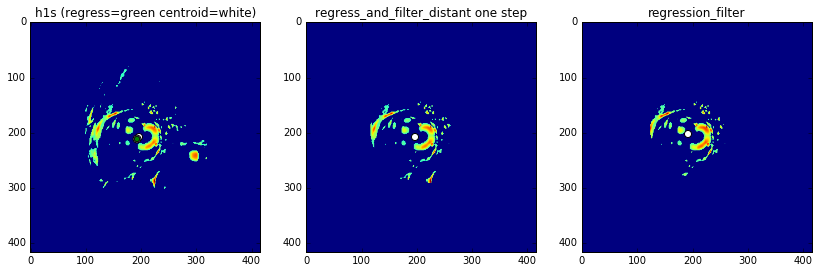

In [45]:
plt.figure(figsize=(14,5))
# Build separatly for x and y a linear regression between slice number and the centroid cordinate
(xslope, xintercept, yslope, yintercept) = regress_centroids(centroids,imgs)
print "regress_centroids",(xslope, xintercept, yslope, yintercept)
raw_coords = np.transpose(np.nonzero(imgs))
# return the coordinates of every non zero pixel, its distance from centroid line and weight (pixel value)
(coords, dists, weights) = get_weighted_distances(imgs, raw_coords,
                                                  xslope, xintercept,
                                                  yslope, yintercept)
plt.subplot(131)
cc = get_centroid(h1s[center_slice])
plt.scatter(cc[1],cc[0],c='w',s=50)
plt.scatter(xintercept + xslope*center_slice,yintercept + yslope*center_slice,c='w',s=60)
plt.scatter(xintercept + xslope*center_slice,yintercept + yslope*center_slice,c='g',s=30)
plt.imshow(h1s[center_slice])
plt.title('h1s (regress=green centroid=white)')

#outliers = get_outliers(coords, dists, weights):
fivep = int(len(weights) * 0.05)
ctr = 1
while True:
    (mean, std, fn) = gaussian_fit(dists, weights)
    low_values = dists < (mean - STD_MULTIPLIER*np.abs(std))
    high_values = dists > (mean + STD_MULTIPLIER*np.abs(std))
    outliers = high_values
#         outliers = np.logical_or(low_values, high_values)
    if len(coords[outliers]) == len(coords):
        # if all are outliers then throw away 5% of all weights and repeat
        weights[-fivep*ctr:] = 0
        ctr += 1
    else:
        outliers =  coords[outliers]
        break

imgs_cpy = np.copy(imgs)
for cc in outliers:
    (z, x, y) = cc
    imgs_cpy[z, x, y] = 0
imgs_filtered = imgs_cpy

plt.subplot(132)
plt.scatter(centroids[center_slice][1],centroids[center_slice][0],c='w',s=50)
plt.imshow(imgs_filtered[center_slice])
plt.title('regress_and_filter_distant one step')

plt.subplot(133)
plt.scatter(c[2],c[1],c='w',s=50)
plt.imshow(regress_h1s[center_slice])
plt.title('regression_filter')

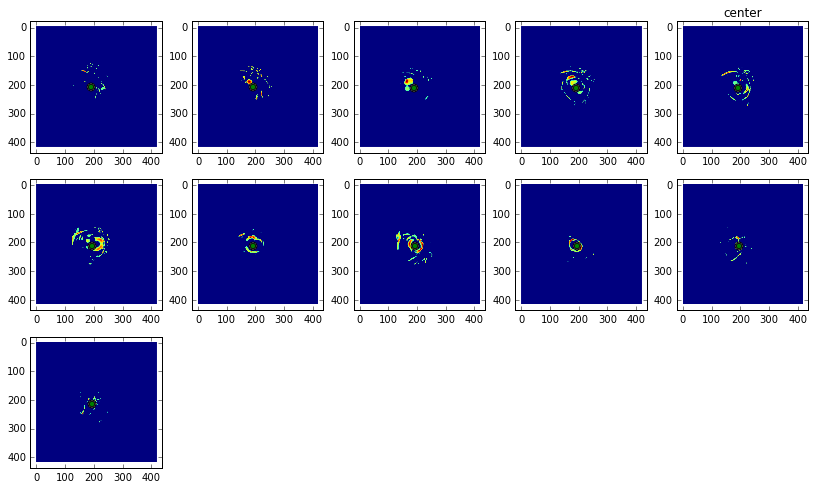

In [46]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(regress_h1s):
    if i == center_slice:
        plt.title('center')
    coords_z = i
    plt.subplot(len(h1s)//5+1,5,i+1)
    plt.imshow(ooo)
    plt.scatter(xintercept + xslope*coords_z, yintercept + yslope*coords_z, c='w',s=60)
    plt.scatter(xintercept + xslope*coords_z, yintercept + yslope*coords_z, c='g',s=30)

#     plt.scatter(coords_x,coords_y,c='w',s=50)

In [47]:
proc_regress_h1s, coords = post_process_regression(regress_h1s)
(xslope, xintercept, yslope, yintercept) = coords

In [48]:
xslope, xintercept, yslope, yintercept

(-0.33769637177184436,
 201.0979949999861,
 0.49987280345264901,
 198.54462439075957)

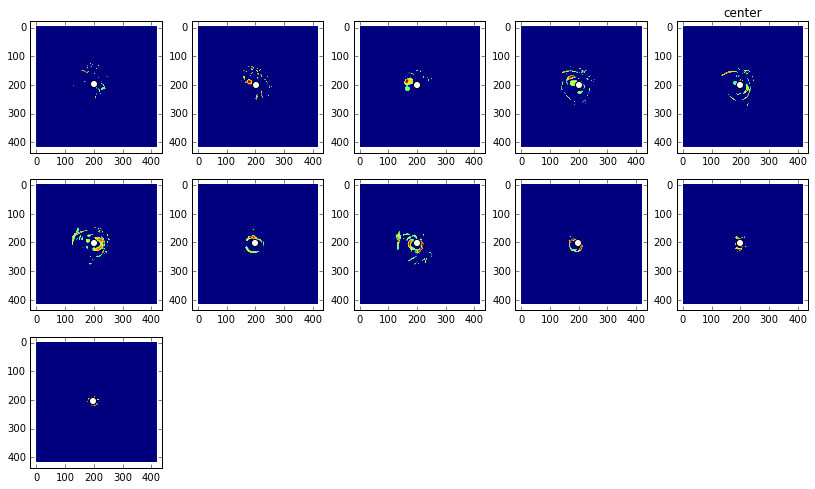

In [49]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(proc_regress_h1s):
    if i == center_slice:
        plt.title('center')
    coords_z = i
    coords_x = xslope*coords_z + xintercept
    coords_y = yslope*coords_z + yintercept
    plt.subplot(len(proc_regress_h1s)//5+1,5,i+1)
    plt.imshow(ooo)
    plt.scatter(coords_x,coords_y,c='w',s=50)


In [50]:
domain = np.arange(1, 100)
(xslope, xintercept, yslope, yintercept) = coords
(num_slices, _, _) = proc_regress_h1s.shape

circles = []
for i in range(num_slices):
    h = proc_regress_h1s[i]
    ctr = (xintercept + xslope * i, yintercept + yslope * i)
    def ratio(r):
        return filled_ratio_of_circle(h, (ctr[0], ctr[1]), r)*r**0.5
    y = np.array([ratio(d) for d in domain])

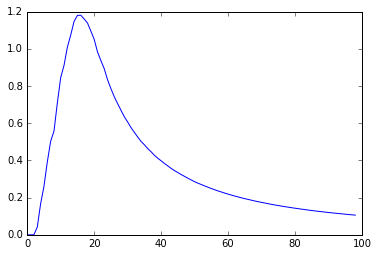

In [51]:
plt.plot(y)

In [52]:
rois, circles = get_ROIs(dc, proc_regress_h1s, coords, rscale=3., pow=.5)

In [53]:
circles

array([[(201.0979949999861, 198.54462439075957), 117.0],
       [(200.76029862821426, 199.04449719421223), 156.0],
       [(200.42260225644242, 199.54436999766486), 138.0],
       [(200.08490588467058, 200.04424280111752), 138.0],
       [(199.74720951289873, 200.54411560457015), 99.0],
       [(199.40951314112687, 201.04398840802281), 99.0],
       [(199.07181676935502, 201.54386121147547), 114.0],
       [(198.73412039758318, 202.04373401492811), 102.0],
       [(198.39642402581134, 202.54360681838077), 105.0],
       [(198.0587276540395, 203.0434796218334), 75.0],
       [(197.72103128226766, 203.54335242528606), 51.0]], dtype=object)

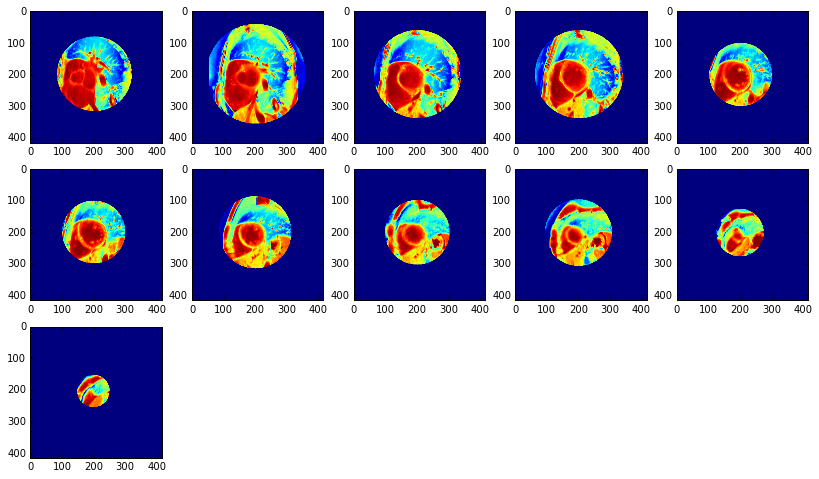

In [54]:
plt.figure(figsize=(14,8))
for i,ooo in enumerate(rois):
    plt.subplot(len(rois)//5+1,5,i+1)
    plt.imshow(ooo)

In [55]:
closest_slice, ctr = get_closest_slice(rois)
closest_slice, ctr

(4, array([   4.15841987,  210.89024863,  196.98432796]))

In [56]:
from IPython.display import Image
import random
from utils import make_gif

make_gif(images[closest_slice], out_file=FN+"demo.gif")
print "original images"
Image(url=FN+"demo.gif?%f"%random.random())

original images


In [57]:
circles[closest_slice],closest_slice

(array([(199.74720951289873, 200.54411560457015), 99.0], dtype=object), 4)

In [58]:
D=50.
pixel = np.sqrt(dset.area)
r = D/pixel

W=1
WW = (2*W+1)
all_results = np.zeros((30,WW*128,WW*128))
for i in range(WW):
    for j in range(WW):
        slice = closest_slice+(i-W)*WW+(j-W)
        if slice < 0 or slice >= len(images):
            continue
            
        circle = np.array([circles[slice][0],r])

        results, scale = get_crop(images[slice], circle)
        print slice, scale,'*' if i == W and j == W else ''
        all_results[:,i*128:(i+1)*128,j*128:(j+1)*128] = results

0 1.20370502464 
1 1.20370502464 
2 1.20370502464 
3 1.20370502464 
4 1.20370502464 *
5 1.20370502464 
6 1.20370502464 
7 1.20370502464 
8 1.20370502464 


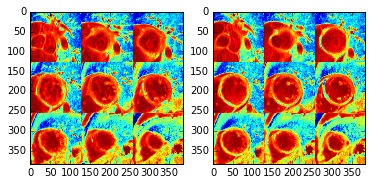

In [59]:
plt.subplot(121)
plt.imshow(all_results[esi])
plt.subplot(122)
plt.imshow(all_results[edi])

In [60]:
from IPython.display import Image
import random
from utils import make_gif

make_gif(all_results, out_file=FN+"demo1.gif")
Image(url=FN+"demo1.gif?%f"%random.random())

# Verify time and DIA and SYS labels

(10, 14)

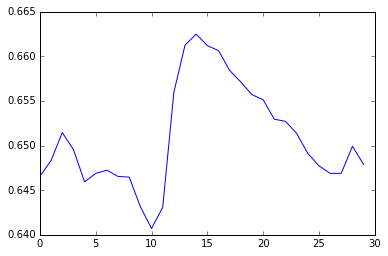

In [61]:
circle = np.array([circles[closest_slice][0],r])

results, scale = get_crop(images[closest_slice], circle)

mean_results = np.array(results).reshape((len(results),-1)).mean(axis=-1)
plt.plot(mean_results)
esi = np.argmin(mean_results)
edi = np.argmax(mean_results)
esi, edi

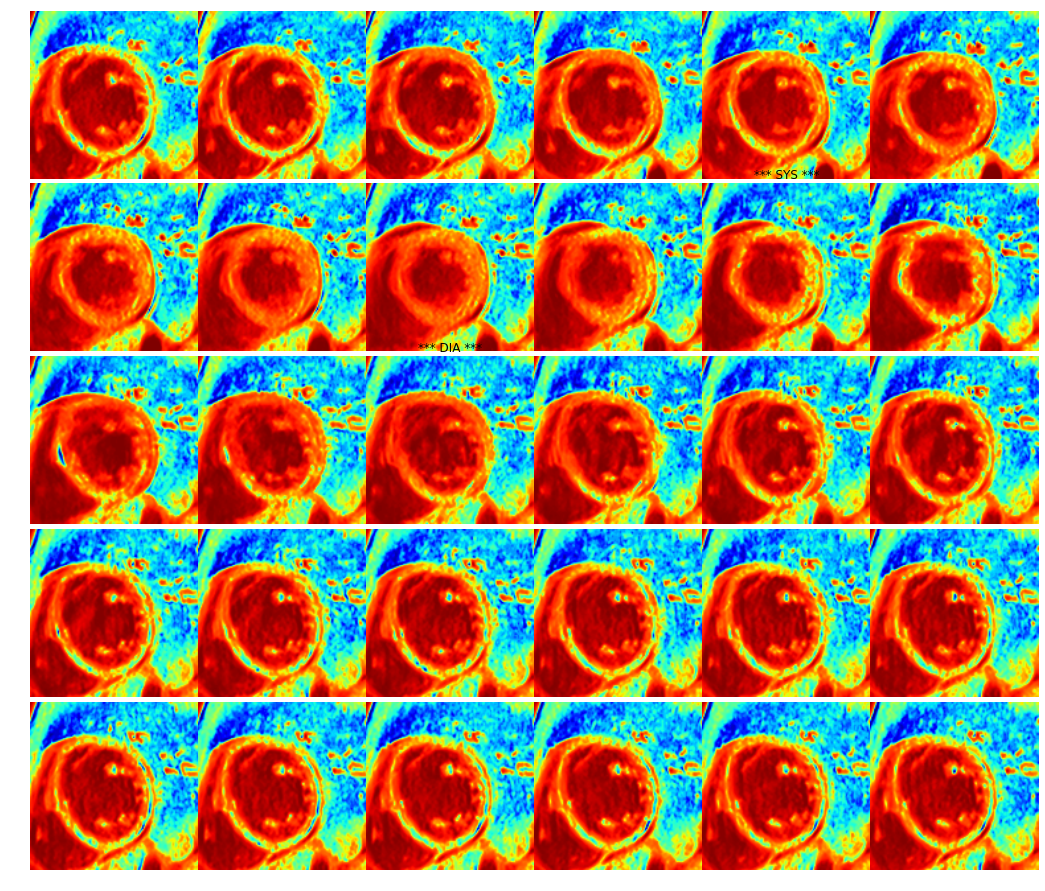

In [62]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for t in range(30):
    plt.subplot(5,6,t+1)
    if t == esi:
        plt.title('*** SYS ***')
    if t == edi:
        plt.title('*** DIA ***')
    plt.imshow(results[t])
    plt.axis('off')

# Verify slice

In [63]:
results = []
for i, c in enumerate(circles):
    circle = np.array([c[0],r])
    result, scale = get_crop([images[i][edi]], circle)
    results.append(result[0])

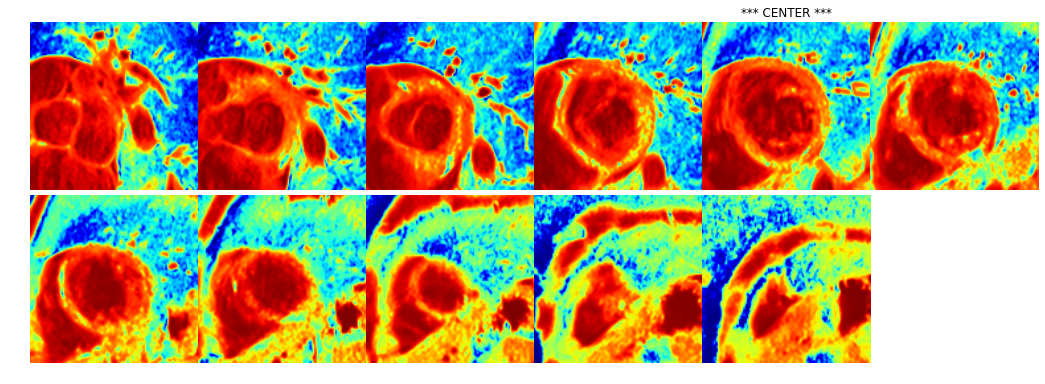

In [64]:
plt.figure(figsize=(14,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for i, img in enumerate(results):
    plt.subplot(5,6,i+1)
    if i == closest_slice:
        plt.title('*** CENTER ***')
    plt.imshow(results[i])
    plt.axis('off')

# Process

In [65]:
from utils import Dataset
# import fasteners

def call(study):
#     with fasteners.InterProcessLock('/tmp/tmp_lock_file'):
#         with open('log','a') as fp:
#             print >>fp,"BEGIN",study
    dset = Dataset(study+1, prefix='sax')
    dset.load(S=-1,Z=30)
    
    images = dset.images.copy()
    for i, imgs in enumerate(images):
        for j, img in enumerate(imgs):
            images[i,j] = cv2.equalizeHist(np.array(img * 255./img.max(), dtype = np.uint8))
    dc = np.mean(images, 1)
    h1s_images = get_H1_noise(images)
        
    h1s_fcn, fcn_center_slice, esi, edi, fcn_scale = get_FCN(study, S=-1)
    
    h1s = 0.5*h1s_fcn/h1s_fcn.max() + 0.5*h1s_images/h1s_images.max()
    
    assert len(h1s) == len(images)
    assert h1s[0].shape == images[0,0].shape
    
    h1s = h1s/256.
    mask = np.zeros_like(h1s[0])
    H,W = mask.shape
    for i in range(H):
        for j in range(W):
            mask[i,j] = - ((i-H/2.)**2 + (j-W/2.)**2)/(2.*min(H,W)**2)
    mask = np.exp(mask)
    mask = mask[None,:,:]
    h1s = h1s * mask
    for i, h1s_s in enumerate(h1s):
        h1s[i][h1s_s < h1s_s.max()*0.4] = 0.
    
    regress_h1s,c = regression_filter(h1s)
    proc_regress_h1s, coords = post_process_regression(regress_h1s)
    rois, circles = get_ROIs(dc, proc_regress_h1s, coords, pow=0.5)
    closest_slice, ctr = get_closest_slice(rois)
    
    D=30.
    pixel = np.sqrt(dset.area)
    r = D/pixel

    circle = np.array([circles[closest_slice][0],r])
    results, scale = get_crop(images[closest_slice], circle)
    
    mean_results = np.array(results).reshape((len(results),-1)).mean(axis=-1)
    esi = np.argmin(mean_results)
    edi = np.argmax(mean_results)
    maxmin_waveform = [esi, edi]
            
#     with fasteners.InterProcessLock('/tmp/tmp_lock_file'):
#         with open('log','a') as fp:
#             print >>fp,"END",study
            
    res = {'circles':circles, 'closest_slice': closest_slice, 'fcn_center_slice': fcn_center_slice,
           'ctr':ctr,
           'maxmin_waveform': maxmin_waveform, 'dist':dset.dist, 'area':dset.area,
           'age':dset.PatientAge, 'sex':dset.PatientSex}
    return res

# testing

In [66]:
study = 414
res = call(study)
res

{'age': 0.8333333333333334,
 'area': 0.41954999999999998,
 'circles': array([[(147.44229491506809, 149.3402200142331), 7],
        [(147.39258467263076, 149.38630387935351), 12],
        [(147.34287443019343, 149.43238774447391), 21],
        [(147.2931641877561, 149.47847160959432), 18],
        [(147.24345394531878, 149.52455547471473), 21],
        [(147.19374370288145, 149.57063933983514), 14],
        [(147.14403346044412, 149.61672320495552), 17],
        [(147.09432321800679, 149.66280707007593), 20],
        [(147.04461297556946, 149.70889093519634), 17]], dtype=object),
 'closest_slice': 5,
 'ctr': array([   4.59610299,  150.45175988,  146.2965975 ]),
 'dist': 5.0,
 'fcn_center_slice': 2,
 'maxmin_waveform': [23, 29],
 'sex': 0}

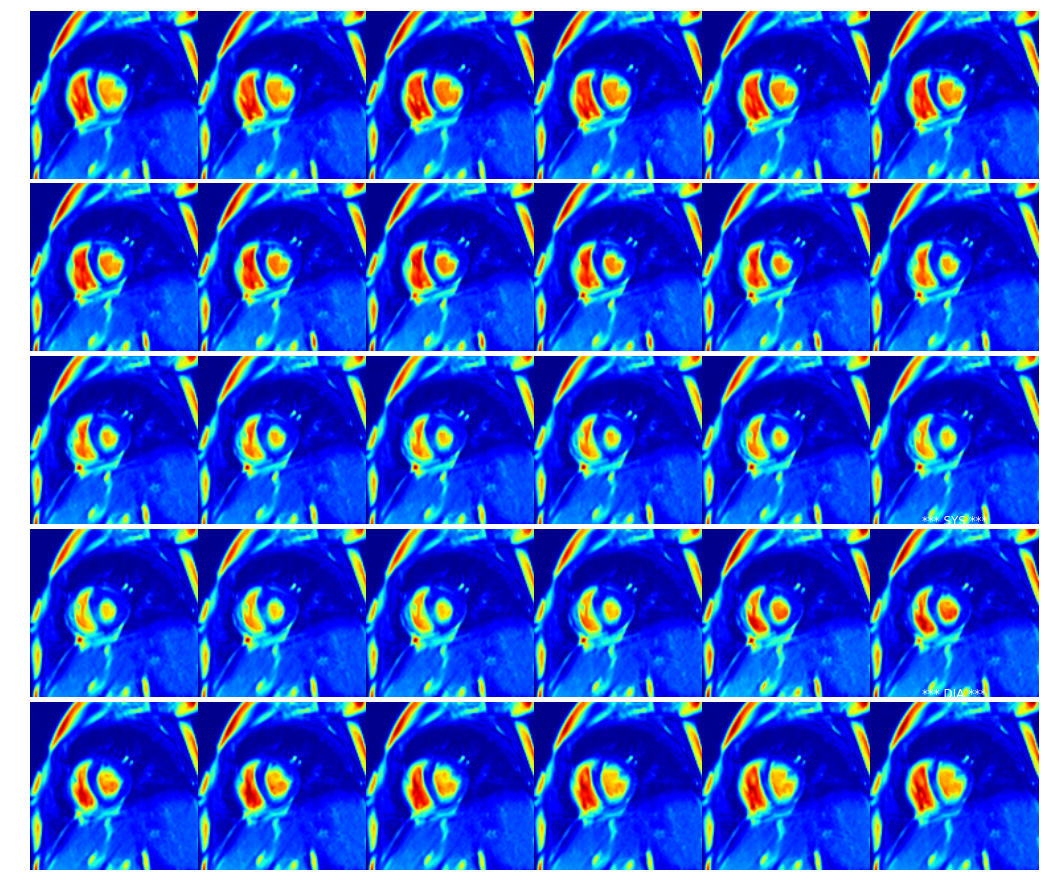

In [67]:
from utils import Dataset
dset = Dataset(study+1, prefix='sax')
dset.load(S=-1)
images = dset.images

closest_slice = res['closest_slice']
D=60.
pixel = np.sqrt(res['area'])
r = D/pixel
circles = res['circles']
circle = np.array([circles[closest_slice][0],r])

results, scale = get_crop(images[closest_slice], circle)

esi, edi = res['maxmin_waveform']
plt.figure(figsize=(14,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for t in range(30):
    plt.subplot(5,6,t+1)
    if t == esi:
        title_obj = plt.title('*** SYS ***')
#         plt.getp(title_obj)                 #print out the properties of title
        if t >= 6:
            plt.setp(title_obj, color='w')
    if t == edi:
        title_obj = plt.title('*** DIA ***')
#         plt.getp(title_obj)                    #print out the properties of title
        if t >= 6:
            plt.setp(title_obj, color='w')
    plt.imshow(results[t])
    plt.axis('off')

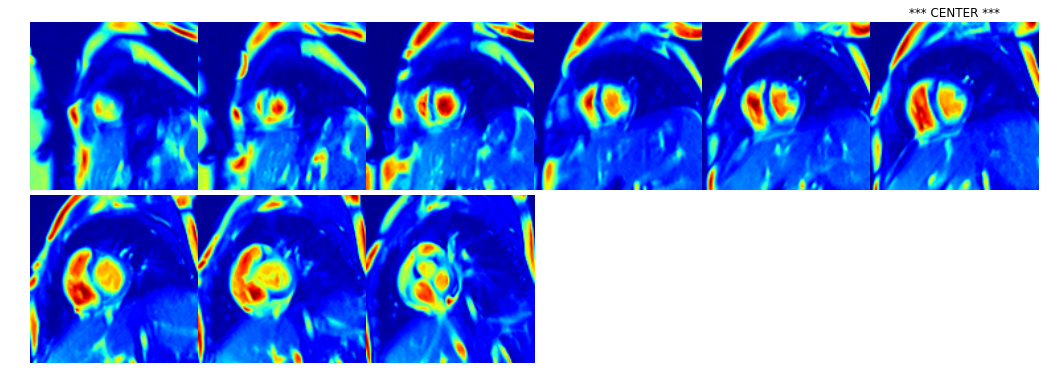

In [68]:
results = []
for i, c in enumerate(circles):
    circle = np.array([c[0],r])
    result, scale = get_crop([images[i][edi]], circle)
    results.append(result[0])

plt.figure(figsize=(14,12))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for i, img in enumerate(results):
    plt.subplot(5,6,i+1)
    if i == closest_slice:
        title_obj = plt.title('*** CENTER ***')
#         plt.getp(title_obj)                    #print out the properties of title
        if i >= 6:
            plt.setp(title_obj, color='w')
    plt.imshow(results[i])
    plt.axis('off')

# Process on all data

I did tried to run this with joblib but always had problems...

In [69]:
import cPickle as pickle
all_results = []
fn = '%s.pkl'%FN
for k in range(Na):
    print k
    res = call(k)
    all_results.append(res)
    if k%10==9 or k == Na-1:
        with open(os.path.join(temp_dir,fn),'wb') as fp:
            pickle.dump(all_results,fp,-1)        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
EMPTY
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
EMPTY
EMPTY
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


In [70]:
fn = '%s.pkl'%FN
awscp(fn, upload=True)